In [5]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import matplotlib.pyplot as plt

EXP_ID = 18439

CHECKPOINT_PATH = f'/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/checkpoint_{EXP_ID}.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [2]:
show_imgs = 5
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, augment=False)
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

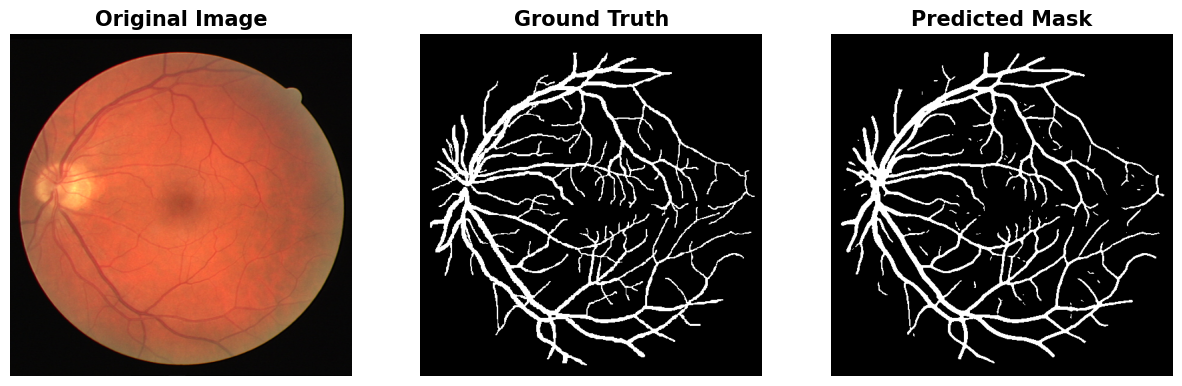

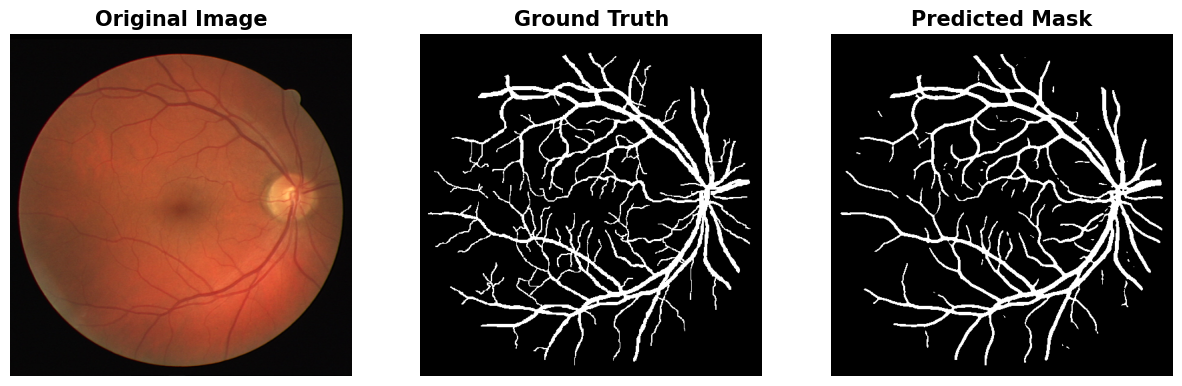

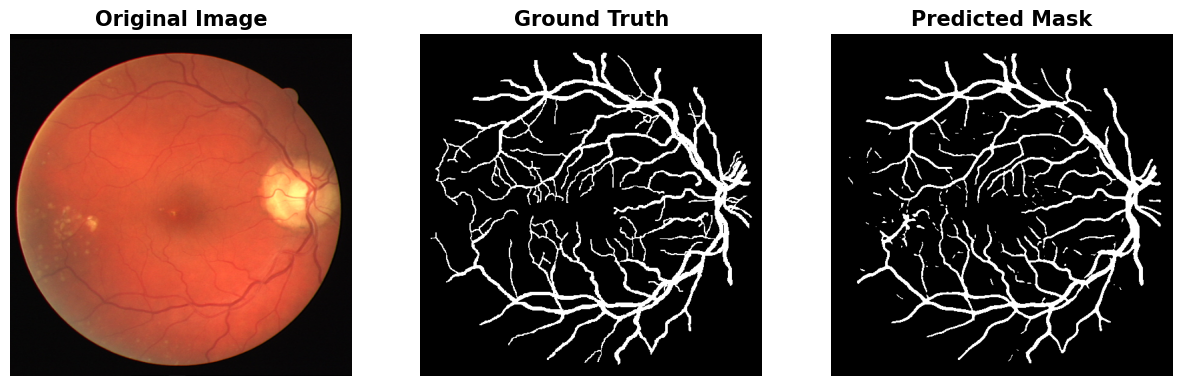

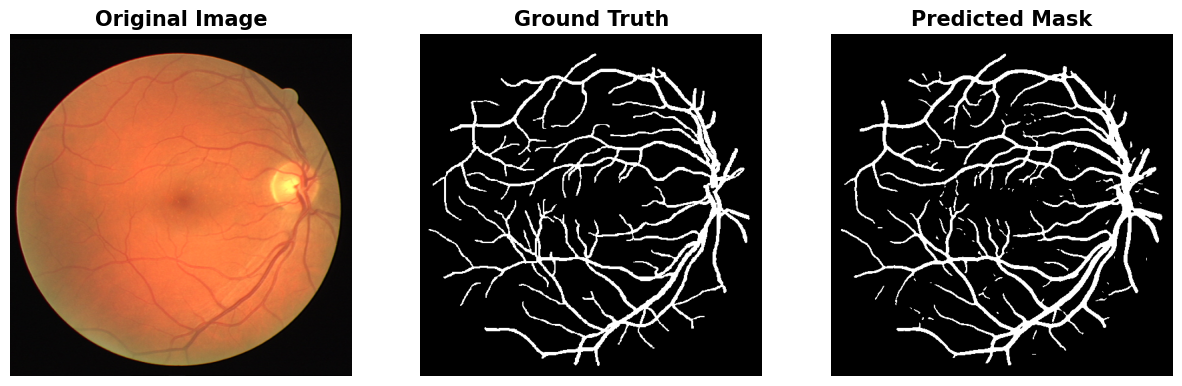

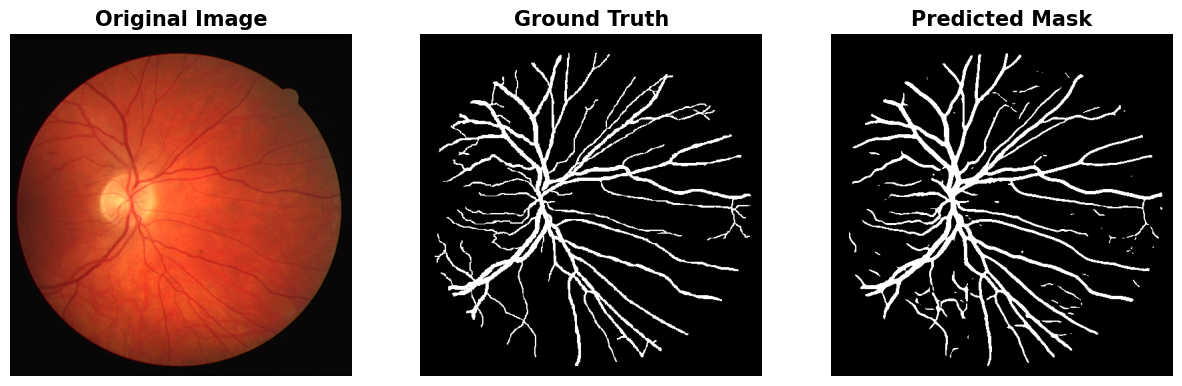

In [4]:
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img.squeeze().permute(1, 2, 0).numpy())
    ax[0].set_title("Original Image", fontsize=15, weight='bold')
    ax[0].axis('off')
    ax[1].imshow(mask.squeeze().numpy(), cmap='gray')
    ax[1].set_title("Ground Truth", fontsize=15, weight='bold')
    ax[1].axis('off')
    ax[2].imshow(pred.squeeze().numpy(), cmap='gray')
    ax[2].set_title("Predicted Mask", fontsize=15, weight='bold')
    ax[2].axis('off')
    plt.show()